In [65]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [66]:
# Constants
NUM_CLASSES = 8

In [67]:
# Load in the data
# data = np.load('../data/segmentedPose.npy')
data = np.load('../data/segmentedPose_augmented.npy')
X = data[:,0:-1]
y = data[:,-1].astype(int)

# Convert y to categorical data
y = to_categorical(y, num_classes=NUM_CLASSES)

In [82]:
# Get training and test splits
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=71)

In [83]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(99,)),
#     tf.keras.layers.Reshape((33, 3)),
#     tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.GlobalMaxPooling1D(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(99,)),
    tf.keras.layers.Reshape((33, 3)),

    tf.keras.layers.Conv1D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv1D(128, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv1D(256, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [84]:
# Initialize optimizer and model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [85]:
# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [86]:
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.2848 - loss: 2.0738 - precision: 0.4164 - recall: 0.1052 - val_accuracy: 0.1253 - val_loss: 2.1727 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4831 - loss: 1.4412 - precision: 0.6754 - recall: 0.2442 - val_accuracy: 0.1253 - val_loss: 2.7039 - val_precision: 0.1340 - val_recall: 0.1229
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5721 - loss: 1.2925 - precision: 0.7394 - recall: 0.3080 - val_accuracy: 0.1253 - val_loss: 3.6545 - val_precision: 0.1253 - val_recall: 0.1253
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6232 - loss: 1.1045 - precision: 0.7582 - recall: 0.4221 - val_accuracy: 0.1253 - val_loss: 5.1841 - val_precision: 0.1253 - val_recall: 0.1253
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6497 - loss: 1.0591 - precision: 0.8020 - recall: 0.4641 - val_accuracy: 0.1253 - val_loss: 6.2

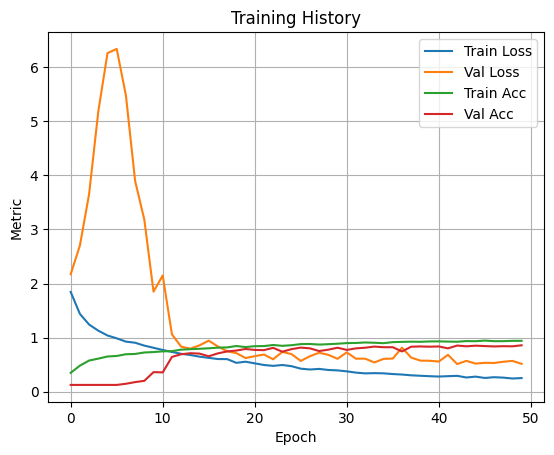

In [88]:
# Plot a training history graph
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
# plt.plot(history.history['precision'], label='Precision')
# plt.plot(history.history['recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.show()